In [26]:
%matplotlib inline
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data.dataloader import default_collate
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from torch.autograd import Variable
print(torch.__version__)

1.0.0


In [42]:
reqd_len = 400
channels = 6
class IMUDataset(Dataset):
    def __init__(self, mode = 'test', transform = None):
        if mode == 'train' :
            self.df = pd.read_csv('final_data/train.csv', header = None)
        elif mode == 'test' :
            self.df = pd.read_csv('final_data/test.csv', header = None)
        elif mode == 'val' :
            self.df = pd.read_csv('final_data/val.csv', header = None)
        self.transform = transform
        print(self.df.shape)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        y = self.df.iloc[idx : idx + reqd_len, 6 : ].values
        ind = np.argmax(np.sum(y, axis = 0))
        label = np.zeros_like(self.df.iloc[0, 6 : ].values)
        label = label.astype('float')
        label[ind] = 1
        x = self.df.iloc[idx : idx + reqd_len, : channels].values
        x = x.astype('float')
        x = x.reshape(reqd_len, channels)
        assert(x.shape == (reqd_len, channels))
        assert(label.shape == (9, ))
        return x, label
        
trainset = IMUDataset(mode = 'train')
valset = IMUDataset(mode = 'val')
testset = IMUDataset(mode = 'test')

(171600, 15)
(21200, 15)
(21200, 15)


In [43]:
train_batch_size = 8
batch_size = 2
train_indices = [(i * reqd_len) for i in range(len(trainset) // reqd_len)]
val_indices = [(i * reqd_len) for i in range(len(valset) // reqd_len)]
test_indices = [(i * reqd_len) for i in range(len(testset) // reqd_len)]

trainloader = DataLoader(trainset, batch_size = train_batch_size, sampler = SubsetRandomSampler(train_indices), drop_last = True)
valloader = DataLoader(valset, batch_size = batch_size, sampler = SubsetRandomSampler(val_indices), drop_last = True)
testloader = DataLoader(testset, batch_size = batch_size, sampler = SubsetRandomSampler(test_indices), drop_last = True)

signal, label = next(iter(trainloader))
print(signal.shape)
print(label.shape)

torch.Size([8, 400, 6])
torch.Size([8, 9])


In [44]:
# print(len(trainloader))
# print(len(testloader))
# print(len(valloader))
def output_size(n, f, p = 0, s = 1):
    return (((n + 2 * p - f) / s) + 1)
print(output_size(400, 3))
print(output_size(398, 3))
print(output_size(396, 3))

398.0
396.0
394.0


In [45]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # defining layers
        self.conv1 = nn.Conv1d(6, 10, 3)
        self.conv2 = nn.Conv1d(10, 15, 3)
        self.conv3 = nn.Conv1d(15, 20, 3)
        self.fc1 = nn.Linear(394 * 20, 512)
        self.fc2 = nn.Linear(512, 9)
        
        nn.init.xavier_uniform_(self.conv1.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.conv2.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.conv3.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.fc1.weight, gain = nn.init.calculate_gain('relu'))
        nn.init.xavier_uniform_(self.fc2.weight, gain = nn.init.calculate_gain('sigmoid'))
        
    def forward(self, signal):
        signal = signal.view(-1, 6, 400)
        out = F.relu(self.conv1(signal))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = out.view(-1, 394 * 20)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        out = F.log_softmax(out, dim = 1)
        return out

Net = ConvNet()
if torch.cuda.is_available():
    print('Model on GPU')
    Net = Net.cuda()

In [46]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Net.parameters(), lr=1e-3)

In [47]:
num_epochs = 30
total_step = len(trainset) // train_batch_size
train_loss_list = list()
val_loss_list = list()
min_val = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, (images, labels) in enumerate(trainloader) :
        if torch.cuda.is_available():
            images = Variable(images).cuda().float()
            labels = Variable(labels).cuda()
        else : 
            images = Variable(images).float()
            labels = Variable(labels)
        
        _, target = torch.max(labels, 1)

        y_pred = Net(images)
        
        loss = criterion(y_pred, target)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 20 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    Net.eval()
    val = []
    with torch.no_grad() :
        for i, (images, labels) in enumerate(valloader) :
            if torch.cuda.is_available():
                images = Variable(images).cuda().float()
                labels = Variable(labels).cuda()
            else : 
                images = Variable(images).float()
                labels = Variable(labels)
                
            _, target = torch.max(labels, 1)

            # Forward pass
            outputs = Net(images)
            loss = criterion(outputs, target)
            val.append(loss)

    val_loss = (sum(val) / len(val)).item()
    val_loss_list.append(val_loss)
    print('epoch : ', epoch, ' / ', num_epochs, ' | TL : ', train_loss, ' | VL : ', val_loss)
    
    if val_loss < min_val :
        print('saving model')
        min_val = val_loss
        torch.save(Net.state_dict(), '3conv2fc_x_acc.pt')

epoch =  0  step =  0  of total steps  21450  loss =  2.3029592037200928
epoch =  0  step =  20  of total steps  21450  loss =  3.008242130279541
epoch =  0  step =  40  of total steps  21450  loss =  1.6029582023620605
epoch :  0  /  30  | TL :  3.006081500143375  | VL :  1.5250192880630493
saving model
epoch =  1  step =  0  of total steps  21450  loss =  1.472991704940796
epoch =  1  step =  20  of total steps  21450  loss =  1.0944197177886963
epoch =  1  step =  40  of total steps  21450  loss =  0.46291738748550415
epoch :  1  /  30  | TL :  0.9185394667229563  | VL :  0.4250469505786896
saving model
epoch =  2  step =  0  of total steps  21450  loss =  0.3366648554801941
epoch =  2  step =  20  of total steps  21450  loss =  1.0221871137619019
epoch =  2  step =  40  of total steps  21450  loss =  0.14349757134914398
epoch :  2  /  30  | TL :  0.3175576704571832  | VL :  0.19555868208408356
saving model
epoch =  3  step =  0  of total steps  21450  loss =  0.07231862097978592
ep

epoch :  26  /  30  | TL :  0.059972180755927564  | VL :  0.084590382874012
epoch =  27  step =  0  of total steps  21450  loss =  0.008648348040878773
epoch =  27  step =  20  of total steps  21450  loss =  0.001362097798846662
epoch =  27  step =  40  of total steps  21450  loss =  0.0009781268890947104
epoch :  27  /  30  | TL :  0.017189878304840398  | VL :  0.04839883744716644
epoch =  28  step =  0  of total steps  21450  loss =  0.0011327445972710848
epoch =  28  step =  20  of total steps  21450  loss =  0.001324089476838708
epoch =  28  step =  40  of total steps  21450  loss =  0.0009485339978709817
epoch :  28  /  30  | TL :  0.016406225004312495  | VL :  0.04894803464412689
epoch =  29  step =  0  of total steps  21450  loss =  0.021415645256638527
epoch =  29  step =  20  of total steps  21450  loss =  0.0005858917720615864
epoch =  29  step =  40  of total steps  21450  loss =  0.45238062739372253
epoch :  29  /  30  | TL :  0.016792639956687675  | VL :  0.071362897753715

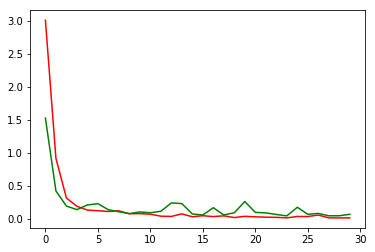

In [48]:
j = np.arange(30)
plt.plot(j, train_loss_list, 'r', j, val_loss_list, 'g')

In [49]:
Net = ConvNet().eval()
Net.load_state_dict(torch.load('3conv2fc_x_acc.pt'))
# print(Net.state_dict())

In [50]:
def _get_accuracy(dataloader):
    total = 0
    correct = 0
    Net.eval()
    for i, (images, labels) in enumerate(dataloader):
        images = Variable(images).float()
        labels = Variable(labels).float()
#         print(images)
        outputs = Net(images)
#         print('Output : ')
#         print(outputs)
        
        _, label_ind = torch.max(labels, 1)
        _, pred_ind = torch.max(outputs, 1)
        
        # converting to numpy arrays
        label_ind = label_ind.data.numpy()
        pred_ind = pred_ind.data.numpy()
        
#         print('Label : ')
#         print(label_ind)
#         print('Prediction : ')
#         print(pred_ind)
        
        # get difference
        diff_ind = label_ind - pred_ind
        # correctly classified will be 1 and will get added
        # incorrectly classified will be 0
        correct += np.count_nonzero(diff_ind == 0)
        total += len(diff_ind)

#         print('correct - ', correct, ' of ', total, 'as of now')
#         print('image - ', total, ' of ', len(dataloader.dataset) // 80)

    accuracy = correct / total
    # print(len(diff_ind))
    return accuracy

Net.cpu()
# _get_accuracy(trainloader)

ConvNet(
  (conv1): Conv1d(6, 10, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(10, 15, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(15, 20, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=7880, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=9, bias=True)
)

In [51]:
print(_get_accuracy(trainloader))
print(_get_accuracy(valloader))
print(_get_accuracy(testloader))

0.9976415094339622
1.0
1.0
